In [1]:
from jax import config
config.update('jax_enable_x64', True)

import jax
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from uncprop.core.inverse_problem import Posterior
from uncprop.models.vsem.inverse_problem import generate_vsem_inv_prob_rep
from uncprop.models.vsem.surrogate import fit_vsem_surrogate

from uncprop.core.surrogate import construct_design
from uncprop.utils.gpjax_models import construct_gp, train_gp_hyperpars
from uncprop.utils.plot import set_plot_theme
from uncprop.utils.grid import Grid, DensityComparisonGrid

colors = set_plot_theme()
key = jr.key(53212)

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
key, key_inv_prob, key_surrogate = jr.split(key, 3)

# settings
noise_sd = 0.1
n_months = 24

inverse_problem_settings = {
    'key': key_inv_prob,
    'par_names': ['kext', 'av'],
    'n_windows': n_months, # note: windows are months
    'n_days_per_window': 30,
    'observed_variable': 'lai',
    'noise_cov_tril': noise_sd * jnp.identity(n_months)
}

surrogate_settings = {
    'key': key_surrogate,
    'n_design': 15,
    'design_method': 'lhc'
}


# construct inverse problem
posterior = generate_vsem_inv_prob_rep(**inverse_problem_settings)

# surrogate-based inverse problem
surrogate_posterior, fit_info = fit_vsem_surrogate(posterior=posterior, **surrogate_settings)

Initial loss 81.57167391970692
Final loss 69.72794649281045
gp scale: 369.2924719652711
gp lengthscales: [0.52418883 0.38525245]
gp noise std dev: 1e-06


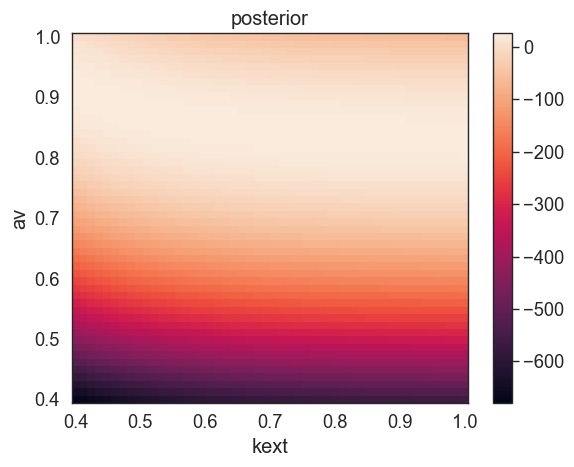

In [3]:
grid = Grid(low=posterior.support[0],
            high=posterior.support[1],
            n_points_per_dim=[50, 50],
            dim_names=posterior.prior.par_names)

fig, ax = grid.plot(f=posterior._get_log_density_function(),
                    title='posterior')

In [ ]:
gp_grid = surrogate_posterior.surrogate(grid.flat_grid)
gp_grid.variance

In [ ]:
gp = surrogate_posterior.surrogate.gp
pred = gp(grid.flat_grid, train_data=surrogate_posterior.surrogate.design)

In [ ]:
pred.variance

In [ ]:
from uncprop.models.vsem.surrogate import _estimate_ep_grid

samp = surrogate_posterior.surrogate(grid.flat_grid).sample(key_ep, n=100)
logp = _estimate_ep_grid(samp, cell_area=grid.cell_area)

In [ ]:
key, key_ep = jr.split(key, 2)

ep = surrogate_posterior.expected_normalized_density_approx(key=key_ep, grid=grid)

grid.plot(f=lambda x: ep.log_density(x))

In [ ]:
# summarize surrogate mean and sd
pred = surrogate_posterior.surrogate(grid.flat_grid)

grid.plot(z=pred.mean, title='surrogate mean')
grid.plot(z=jnp.sqrt(pred.variance), title='surrogate sd')

In [ ]:
# sampling posterior
key, key_mcmc = jr.split(key, 2)

samp = posterior.sample(key, n=3000, num_warmup_steps=500) # returns HMCState with samp.position (n, 1, 2)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(samples[:,0])
plt.show()

### Fit Surrogate

In [ ]:
key, key_design = jr.split(key, 2)

# sample design points
design = construct_design(key=key_design,
                          design_method='lhc', 
                          n_design=15, 
                          prior=posterior.prior,
                          f=lambda x: posterior.log_density(x))

# fit log-posterior surrogate
surrogate = VSEMSurrogate(design=design, exact_posterior=posterior)
surrogate.summarize_fit()

In [ ]:
# summarize surrogate mean and sd
pred = surrogate(grid.flat_grid)

grid.plot(z=pred.mean, title='surrogate mean')
grid.plot(z=jnp.sqrt(pred.variance), title='surrogate sd')

In [ ]:
from uncprop.core.surrogate import LogDensGPSurrogate

surrogate_post = LogDensGPSurrogate(log_dens=surrogate, support=posterior.support)

In [ ]:
dists = {
    'exact': posterior,
    'mean': surrogate_post.expected_surrogate_approx(),
    'eup': surrogate_post.expected_density_approx()
}

density_comparison = DensityComparisonGrid(grid=grid, distributions=dists)

In [ ]:
density_comparison.plot(['exact', 'mean', 'eup'],
                         normalized=True, log_scale=False,
                         max_cols=3)